# Solving manufacturing problem using GA

minimize $f_1=100\times x_1 + 150\times x_2 + 200\times y_1 + 50\times y_2$

minimize $f_2=|(2\times x_1 + 4\times y_1) - (3\times x_2 + y_2)|$

s.t. 

$x_1+x_2\ge 100$

$y_1+x_y\ge 100$

$x_1, x_2, y_1, y_2 \ge 0$

where 

$x_1$ and $x_2$ are the number of units of product P1 produced on machines M1 and M2, respectively,

$y_1$ and $y_2$ are the number of units of product P2 produced on machines M1 and M2, respectively,

$f_1$ is the total production costs and 

$f_2$ is the difference in production times between the two machines.

### Define the problem

In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class ManufacturingProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([0,0,0,0]),
                         xu=np.array([100,100,1000,1000]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100*x[0] + 150*x[1] + 200*x[2] + 50*x[3] # total production costs
        f2 = np.abs((2*x[0] + 4*x[2]) - (3*x[1] + x[3])) # difference in production times between the two machines

        g1 = -x[0] - x[1] + 100
        g2 = -x[2] - x[3] + 100

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]

problem = ManufacturingProblem()

### Define the solver

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

### Define termination criterion

In [3]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)

### Run the solver

In [4]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      2 |  0.000000E+00 |  1.946362E+01 |             - |             -
     2 |       50 |      4 |  0.000000E+00 |  6.9325484424 |  0.0026165229 |         ideal
     3 |       60 |      4 |  0.000000E+00 |  1.3696814445 |  0.0126384359 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  0.000000E+00 |  0.6355329267 |         ideal
     5 |       80 |      3 |  0.000000E+00 |  0.000000E+00 |  0.4430607948 |         ideal
     6 |       90 |      4 |  0.000000E+00 |  0.000000E+00 |  0.1905202599 |         ideal
     7 |      100 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0110478459 |         ideal
     8 |      110 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      120 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0257328604 |             f
    10 |      130 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0418189210 |             f

### Visualize the Pareto-front 

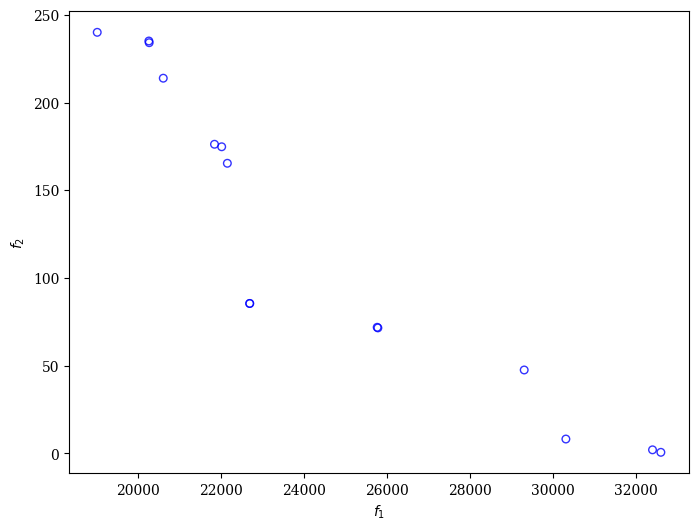

In [5]:
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="blue", s=30, alpha=0.8)
plot.show()

### Multi-Criteria Decision Making

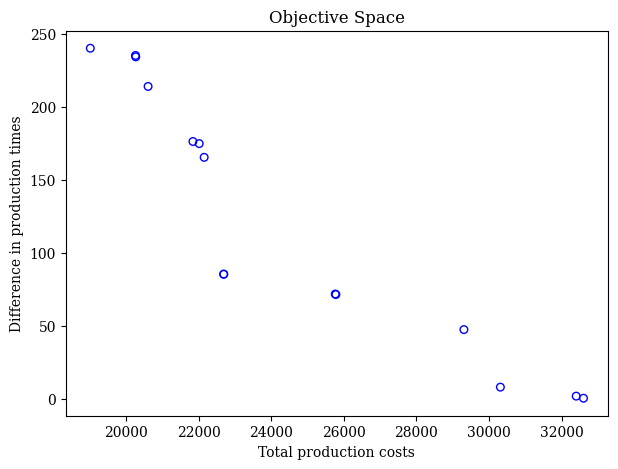

In [6]:
F = res.F
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("Total production costs")
plt.ylabel("Difference in production times")
plt.show()

### Defining the boundary points and Normalization

The ideal and nadir points are used in multi-objective optimization problems to normalize the objective functions and convert them to a common scale, allowing for a fair comparison of different solutions.

* <b>The ideal point:</b> refers to the best possible values for each objective function that can be achieved in the entire feasible region of the problem. It is the point where all the objective functions are minimized simultaneously.
* <b>The nadir point:</b> is the point where each objective function is maximized while satisfying all the constraints of the problem. It is the opposite of the ideal point and represents the worst possible values for each objective function in the entire feasible region of the problem.

In [7]:
F = res.F

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

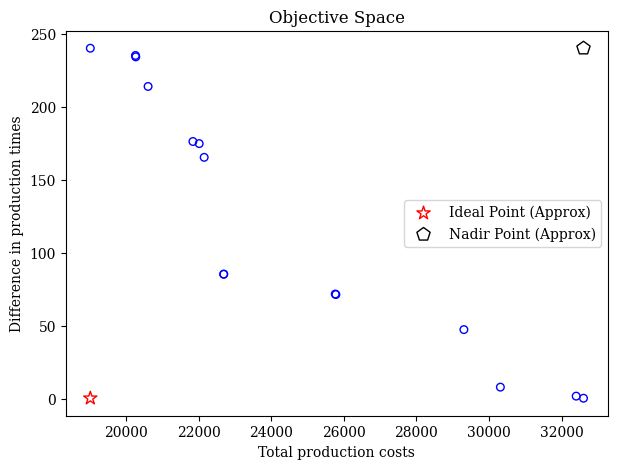

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.xlabel("Total production costs")
plt.ylabel("Difference in production times")
plt.legend()
plt.show()

In [9]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

### Defining weights required by decomposition functions

In [10]:
weights = np.array([0.2, 0.8]) # weights for f1 and f2

### Defining a decomposition method using Augmented Scalarization Function (ASF)

In [11]:
from pymoo.decomposition.asf import ASF

decomp = ASF()

#### Finding solutions
Choose the minimum ASF values calculated from all solutions and use inverse of the weights as per ASF requirements because ASF is supposed to be minimized

In [12]:
i = decomp.do(nF, 1/weights).argmin()

### Visualize the results

Best regarding ASF: Point 
i = 13
F = [29309.80603007    47.55904404]


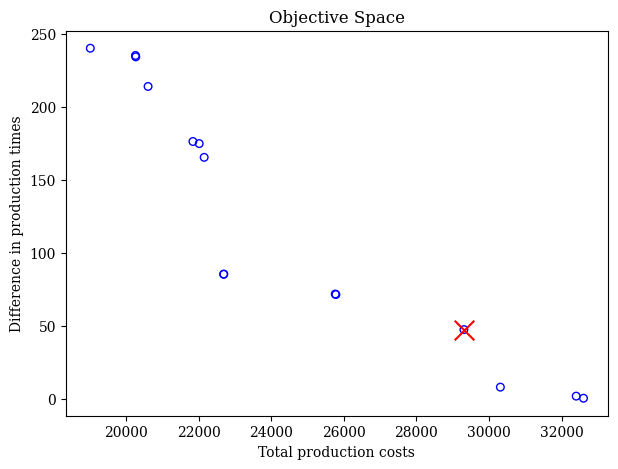

In [13]:
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.xlabel("Total production costs")
plt.ylabel("Difference in production times")
plt.show()

### Pseudo-Weights

Another method to chose a solution out of a solution set in the context of multi-objective optimization

In [14]:
from pymoo.mcdm.pseudo_weights import PseudoWeights

i = PseudoWeights(weights).do(nF)

Best regarding Pseudo Weights: Point 
i = 13
F = [29309.80603007    47.55904404]


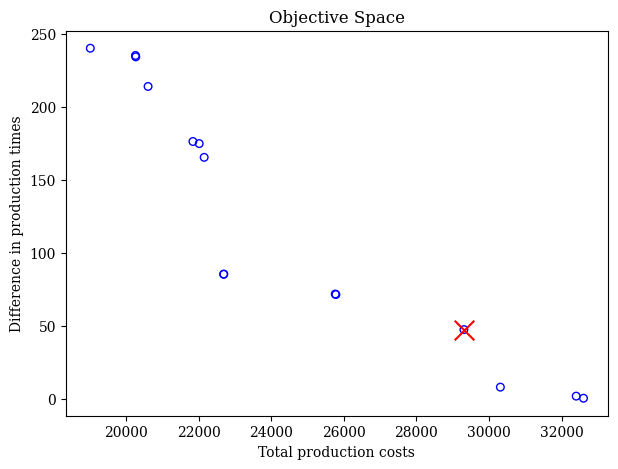

In [15]:
print("Best regarding Pseudo Weights: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.xlabel("Total production costs")
plt.ylabel("Difference in production times")
plt.show()

### Print the solution

In [16]:
soln=np.asarray(X[i], dtype = 'int')

print("The best solution found: ")

print("Number of units of product P1 produced on machines M1 and M2 are", soln[0] , "and", soln[1], "respectively")

print("Number of units of product P2 produced on machines M1 and M2 are", soln[2] , "and", soln[3], "respectively")

print("The total production costs are", round(F[i][0],2))

print("The difference in production times between the two machines is", round(F[i][1]))

The best solution found: 
Number of units of product P1 produced on machines M1 and M2 are 35 and 72 respectively
Number of units of product P2 produced on machines M1 and M2 are 49 and 98 respectively
The total production costs are 29309.81
The difference in production times between the two machines is 48
